In [1]:
#Libraries
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

#Configuration for the font and style in the graphics
params = {
        'font.family': 'serif',
        'font.serif': ['STIXGeneral', 'Times New Roman'],
        'font.size': 16,
        'axes.labelsize': 16,
        'axes.titlesize': 18,
        'legend.fontsize': 16,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'figure.figsize': (6.4, 4.8),
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight'
    }
    
plt.rcParams.update(params)

In [2]:
#Lines from the excel files
VIS_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Final data\Values VIS.xlsx")
NIR_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Final data\Values NIR.xlsx")
SPA_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Spatially Resolved Atlas\Data\Values_SPA.xlsx")
ALL_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Final data\Values ALL.xlsx")


## Gray and Oostra standard curve

### Give a third order polynomial fit for each color

The range used on Gray and Oostra article for the standard curve was 6020–6340 Å, we can stablish just a green range (4970-5700 Å) for comparised and report all the color curves started on violet range.

For consistency, the standard curve is comparised only using the visible range for the solar flux atlas.

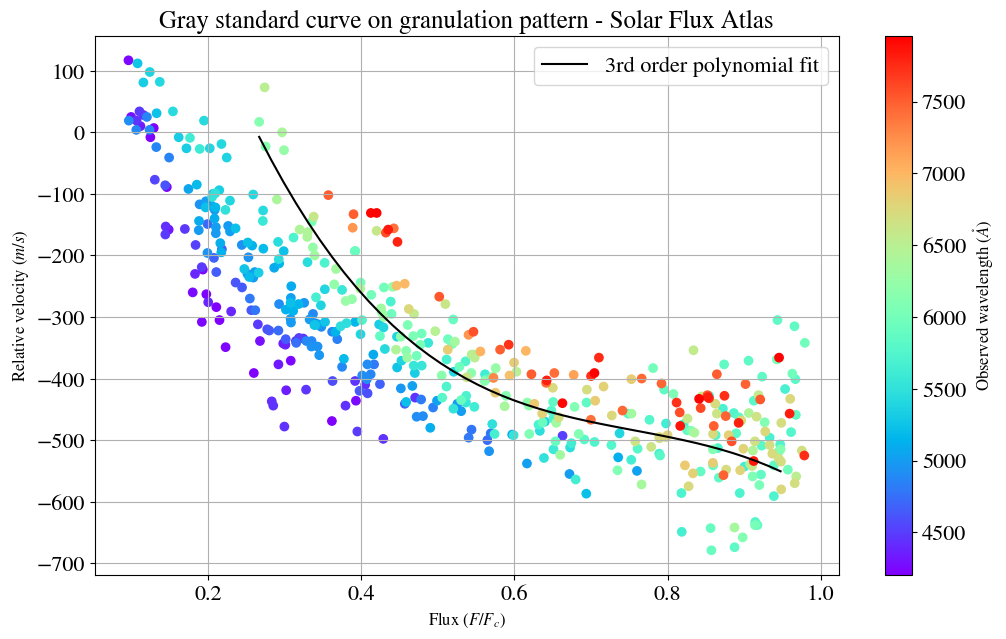

In [3]:
#Take the range from Gray and Oostra
values_VIS_standard = VIS_data[VIS_data['Observed wavelength'].between(6020,6340, inclusive='right')]

fig1, ax = plt.subplots(1,1,figsize=(12,7))

ax.set_title(r'Gray standard curve on granulation pattern - Solar Flux Atlas')

pol = Polynomial.fit(values_VIS_standard['Flux'],values_VIS_standard['Velocity'], 3)
param = pol.convert().coef
values_flux = np.linspace(min(values_VIS_standard['Flux']), max(values_VIS_standard['Flux']), len(values_VIS_standard['Flux']))
flux_fit = poly.polyval(values_flux,param)

scatter = ax.scatter(VIS_data['Flux'],VIS_data['Velocity'],c=VIS_data["Observed wavelength"],cmap='rainbow',lw=1,marker='o')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.plot(values_flux,flux_fit,color='k',label='3rd order polynomial fit')

ax.set_xlabel(r'Flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Relative velocity $(m/s)$',fontsize=12)
ax.legend()
ax.grid()

# fig1.savefig('Standard curve_Gray.pdf')

The report is only for the specific range and shifted the curved +633 m/s

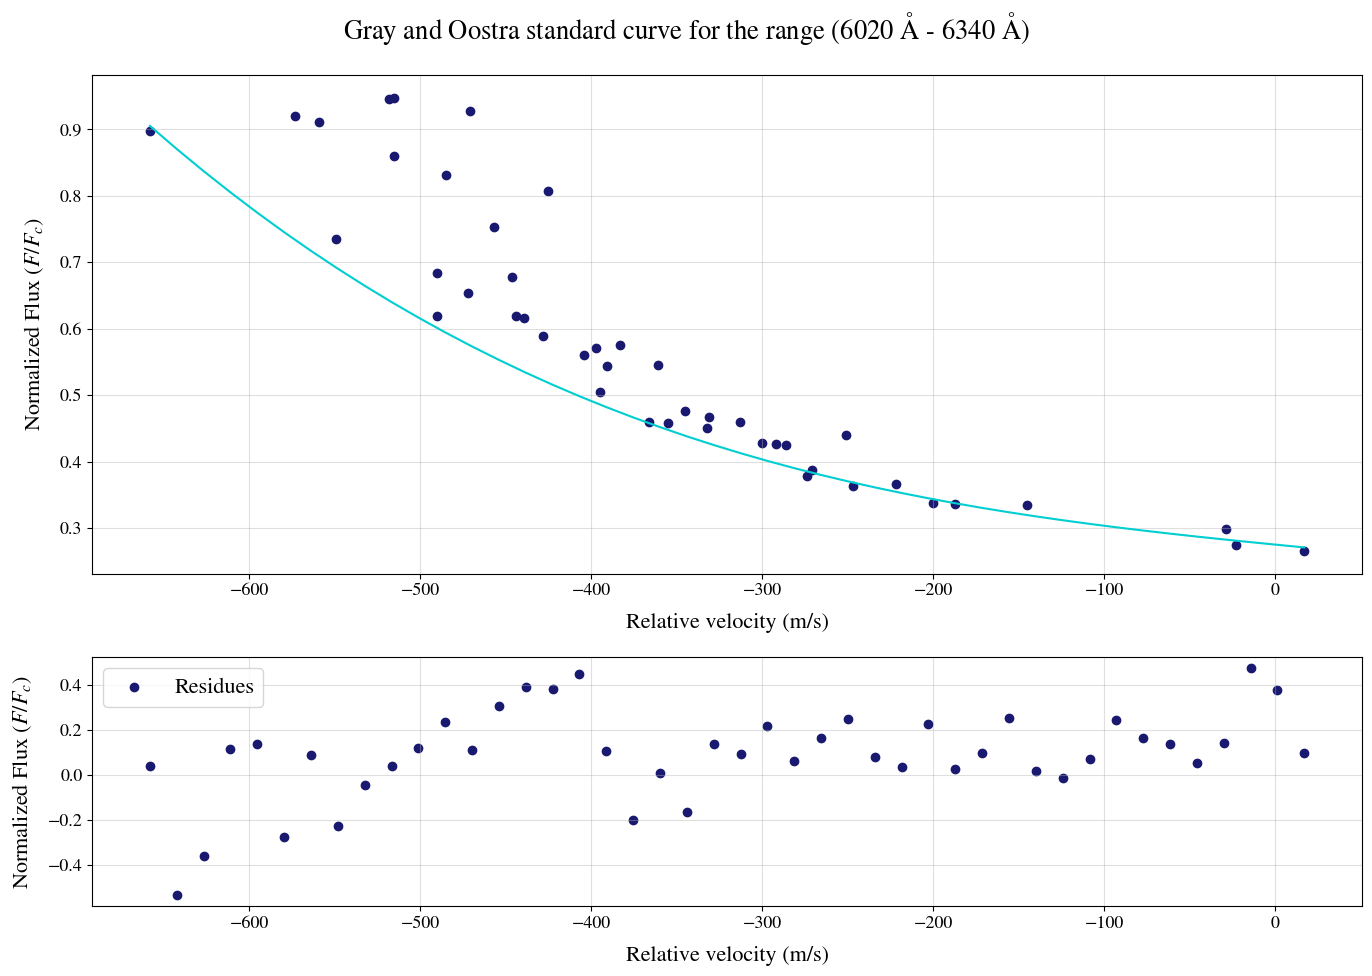

In [4]:
#In the report is given in function of the velocity
Gray_params = [ -0.1364*10**(-8),0.1731*10**(-6),-0.2521*10**(-3),0.2758]

values_fit = np.linspace(min(values_VIS_standard['Velocity']), max(values_VIS_standard['Velocity']), len(values_VIS_standard))

fit = np.polyval(Gray_params,values_fit)

#Calculate the residues
residuos = values_VIS_standard['Flux']-fit
std_flux = np.std(residuos) 

#Plot for fixed the zero point of velocity
fig2, axis = plt.subplots(2,1, figsize = (14, 10), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis[0]
ax2 = axis[1]

fig2.suptitle(r'Gray and Oostra standard curve for the range (6020 $\mathrm{\AA}$ - 6340 $\mathrm{\AA}$)')

ax1.scatter(values_VIS_standard['Velocity'],values_VIS_standard['Flux'], color='midnightblue')
ax1.plot(values_fit,fit,c='darkturquoise',
    label= fr'$F/F_c$ = -{round(Gray_params[0]*1e9,4)} $\times 10^{{-9}}v^3$ +{round(Gray_params[1]*-1e6,4)}$\times 10^{{-6}}v^2$ - {round(Gray_params[2]*-1e3,4)} $\times 10^{{-3}}v$ + {round(Gray_params[3]*10,4)}')
ax1.set_ylabel(r'Normalized Flux $(F/F_{c})$',labelpad=10)
ax1.set_xlabel(r'Relative velocity (m/s)',labelpad=10)
ax1.grid(alpha=0.4)
ax1.tick_params(axis='both',labelsize=13)

ax2.scatter(values_fit,residuos,c='midnightblue',label='Residues')
ax2.set_xlabel(r'Relative velocity (m/s)',labelpad=10)
ax2.set_ylabel(r'Normalized Flux $(F/F_{c})$',labelpad=10)
ax2.grid(alpha=0.4)
ax2.legend()
ax2.tick_params(axis='both',labelsize=13)


fig2.tight_layout()

# fig2.savefig('Standard curve gray')

In [5]:
param

array([ 1024.50084464, -5515.98259757,  6984.65788667, -3079.10441021])

### Standard curves for visible range

In [6]:
#Separate for range in colors for color fits

values_ALL = [ ALL_data[ALL_data['Observed wavelength'].between(3800, 4270, inclusive='right') ], #Purple
                ALL_data[ALL_data['Observed wavelength'].between(4270, 4760, inclusive='right')], #Blue
                ALL_data[ALL_data['Observed wavelength'].between(4760, 4970, inclusive='right')], #Cyan
                ALL_data[ALL_data['Observed wavelength'].between(4970, 5700, inclusive='right')], #Green 
                ALL_data[ALL_data['Observed wavelength'].between(5700, 6180, inclusive='right')], #Orange
                ALL_data[ALL_data['Observed wavelength'].between(6180, 7500, inclusive='right')]] #Red

#colors for the plot
colors_fit = [r'3800 $\mathrm{\AA}$ - 4270 $\mathrm{\AA}$',r'4270 $\mathrm{\AA}$ - 4760 $\mathrm{\AA}$',r'4760 $\mathrm{\AA}$ - 4970 $\mathrm{\AA}$',
              r'4970 $\mathrm{\AA}$ - 5700 $\mathrm{\AA}$',r'5700 $\mathrm{\AA}$ - 6180 $\mathrm{\AA}$',r'6180 $\mathrm{\AA}$ - 7500 $\mathrm{\AA}$']
colors = ['darkviolet','darkblue','darkcyan','darkgreen','darkorange','darkred']
colors_wave = [np.mean(np.arange(3800, 4270,1)),np.mean(np.arange(4270, 4760,1)),np.mean(np.arange(4760, 4970,1)),
               np.mean(np.arange(4970, 5700,1)),np.mean(np.arange(5700, 6180,1)),np.mean(np.arange(6180, 7500,1))]


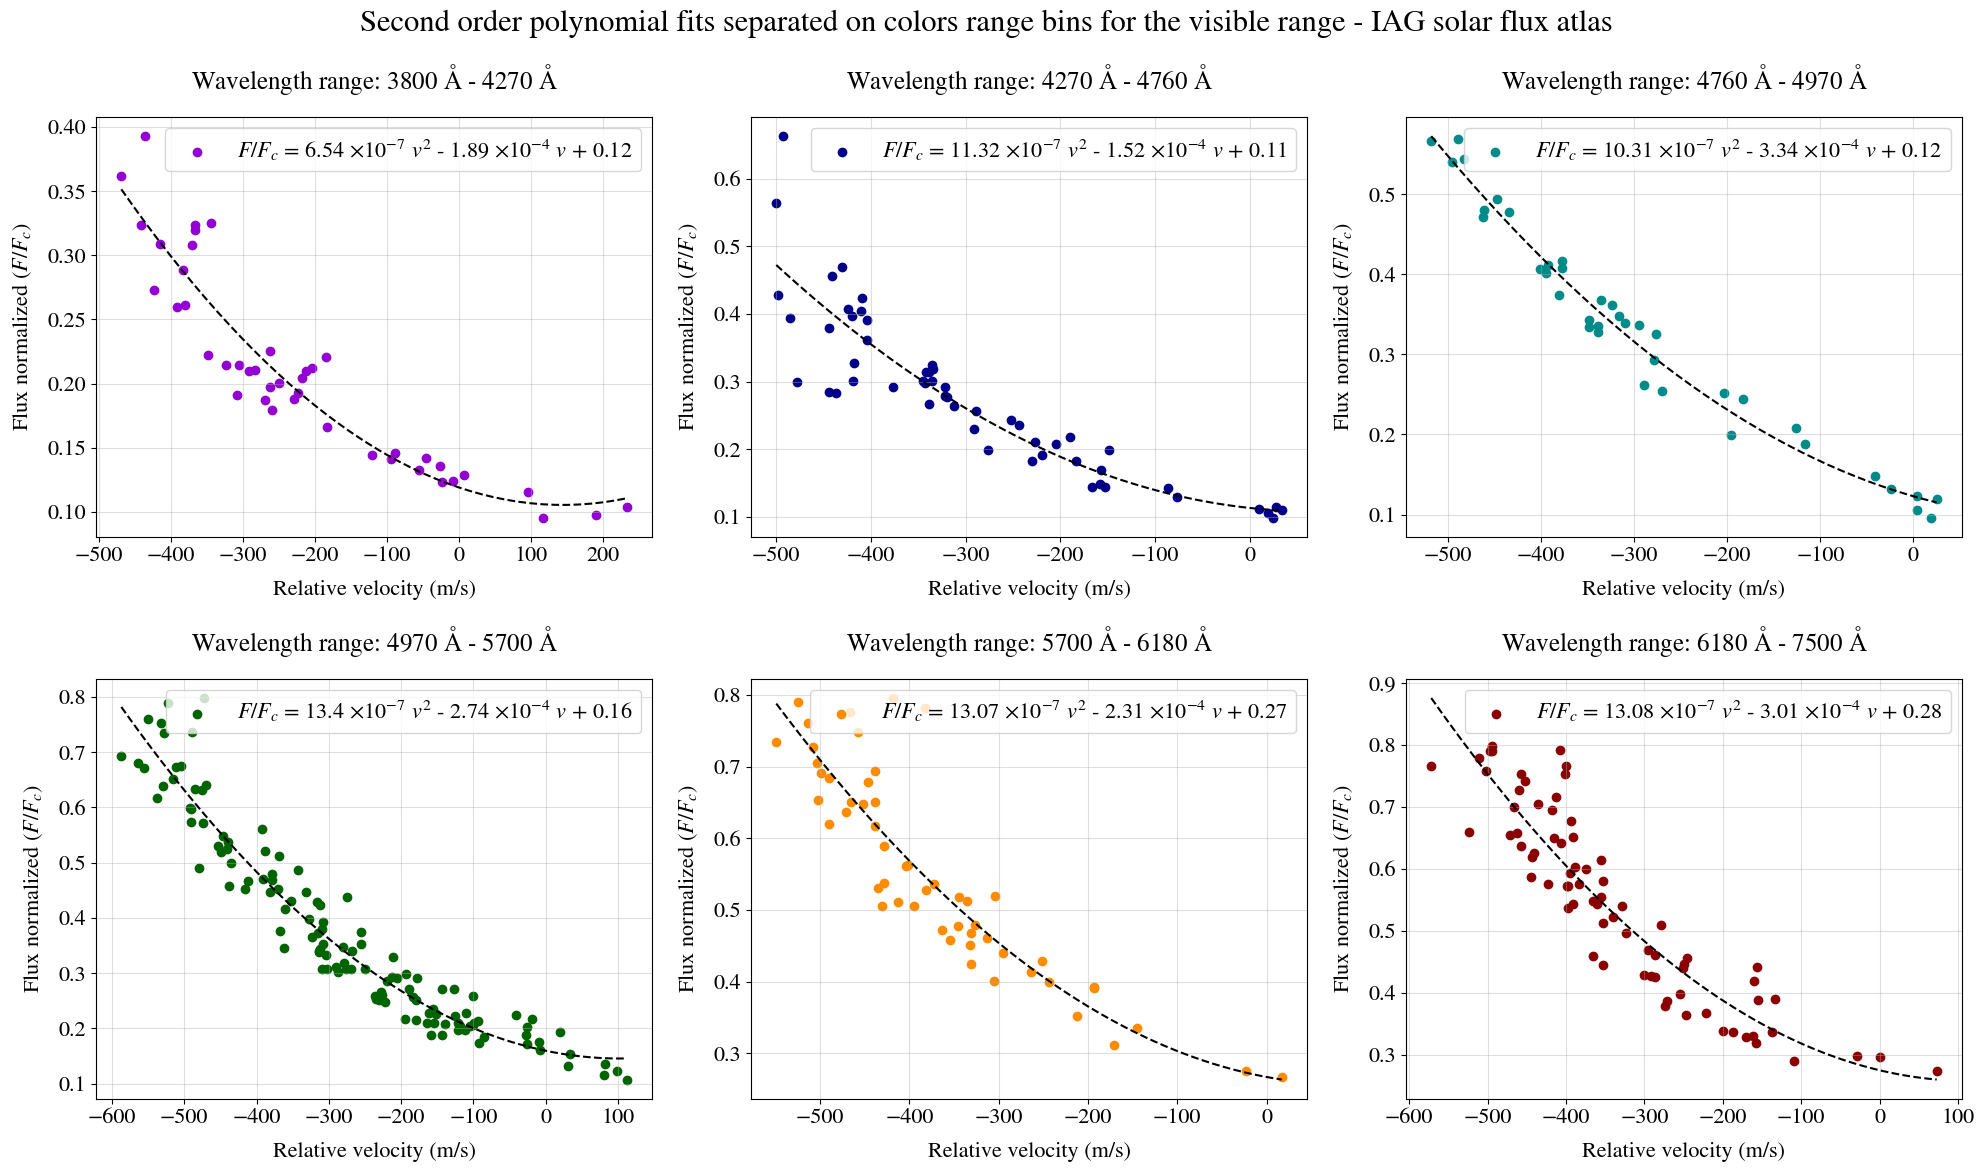

In [ ]:
fig5, axes = plt.subplots(2,3,figsize=(20,12))
fig5.suptitle('Second order polynomial fits separated on colors range bins for the visible range - IAG solar flux atlas',fontsize=22)
axes = axes.flatten()

cov_error = []
r2 = []
fits = []
values_param = []
#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):
        if i < len(values_ALL):
                data = values_ALL[i][values_ALL[i]['Flux'].between(0,0.8)]

                #Made a polynomial first order fit
                param, cov = np.polyfit(data['Velocity'],data['Flux'], 2,cov=True)
                values_fit = np.linspace(min(data['Velocity']), max(data['Velocity']), len(data['Velocity']))
                fit = np.polyval(param,values_fit)
                # Standard error
                error = np.sqrt(np.diag(cov))
                #Calcule the pearson coeffcient where R2=r2
                r = data['Velocity'].corr(pd.Series(fit, index=data.index))

                cov_error.append(pd.DataFrame(error))
                r2.append(r**2)
                fits.append([values_fit,fit])
                values_param.append(pd.DataFrame(param))

                ax.plot(values_fit,fit, color='k',linestyle='--')
                ax.scatter(data['Velocity'],data['Flux'],c=colors[i],label=rf'$F/F_c$ = {round(param[0]*1e7,2)} $\times 10^{{-7}}$ $v^2$ - {round(param[1]*-1e4,2)} $\times 10^{{-4}}$ $v$ + {round(param[2],2)}')
                ax.set_title(r'Wavelength range: {}'.format(colors_fit[i]),pad=20)
                ax.grid(alpha=0.4)
                ax.legend()

                ax.set_ylabel(r'Flux normalized $(F/F_{c})$',labelpad=10)
                ax.set_xlabel(r'Relative velocity (m/s)',labelpad=10)

        else:
                ax.remove()

fig5.tight_layout()
# fig5.savefig('color curves VIS')


In [8]:
#Parameters and their error
param_VIS = pd.concat(values_param,axis=1).T.reset_index(drop=True)
param_VIS.columns = ['Cuadratic','Lineal','Shift']
param_VIS['Error Cuadratic'] = pd.concat(cov_error,axis=1).T.reset_index(drop=True)[0]
param_VIS['Error Lineal'] = pd.concat(cov_error,axis=1).T.reset_index(drop=True)[1]
param_VIS['Error Shift'] = pd.concat(cov_error,axis=1).T.reset_index(drop=True)[2]
param_VIS['Range'] = colors_wave
param_VIS['Color range'] = colors_fit
param_VIS

,Cuadratic,Lineal,Shift,Error Cuadratic,Error Lineal,Error Shift,Range,Color range
0,6.543126e-07,-0.000189,0.119098,1.226896e-07,0.000043,0.006852,4034.5,3800 $\mathrm{\AA}$ - 4270 $\mathrm{\AA}$
1,1.132448e-06,-0.000152,0.113453,3.043728e-07,0.000154,0.018838,4514.5,4270 $\mathrm{\AA}$ - 4760 $\mathrm{\AA}$
2,1.030765e-06,-0.000334,0.122773,1.472809e-07,0.000073,0.008567,4864.5,4760 $\mathrm{\AA}$ - 4970 $\mathrm{\AA}$
3,1.339657e-06,-0.000274,0.159545,1.331424e-07,0.000073,0.009454,5334.5,4970 $\mathrm{\AA}$ - 5700 $\mathrm{\AA}$
4,1.306669e-06,-0.000231,0.267052,4.235534e-07,0.000265,0.041203,5939.5,5700 $\mathrm{\AA}$ - 6180 $\mathrm{\AA}$
5,1.307967e-06,-0.000301,0.275323,3.133862e-07,0.000184,0.026637,6839.5,6180 $\mathrm{\AA}$ - 7500 $\mathrm{\AA}$


In [9]:
# param_VIS.to_excel('Standard coefficients.xlsx',index_label=False)

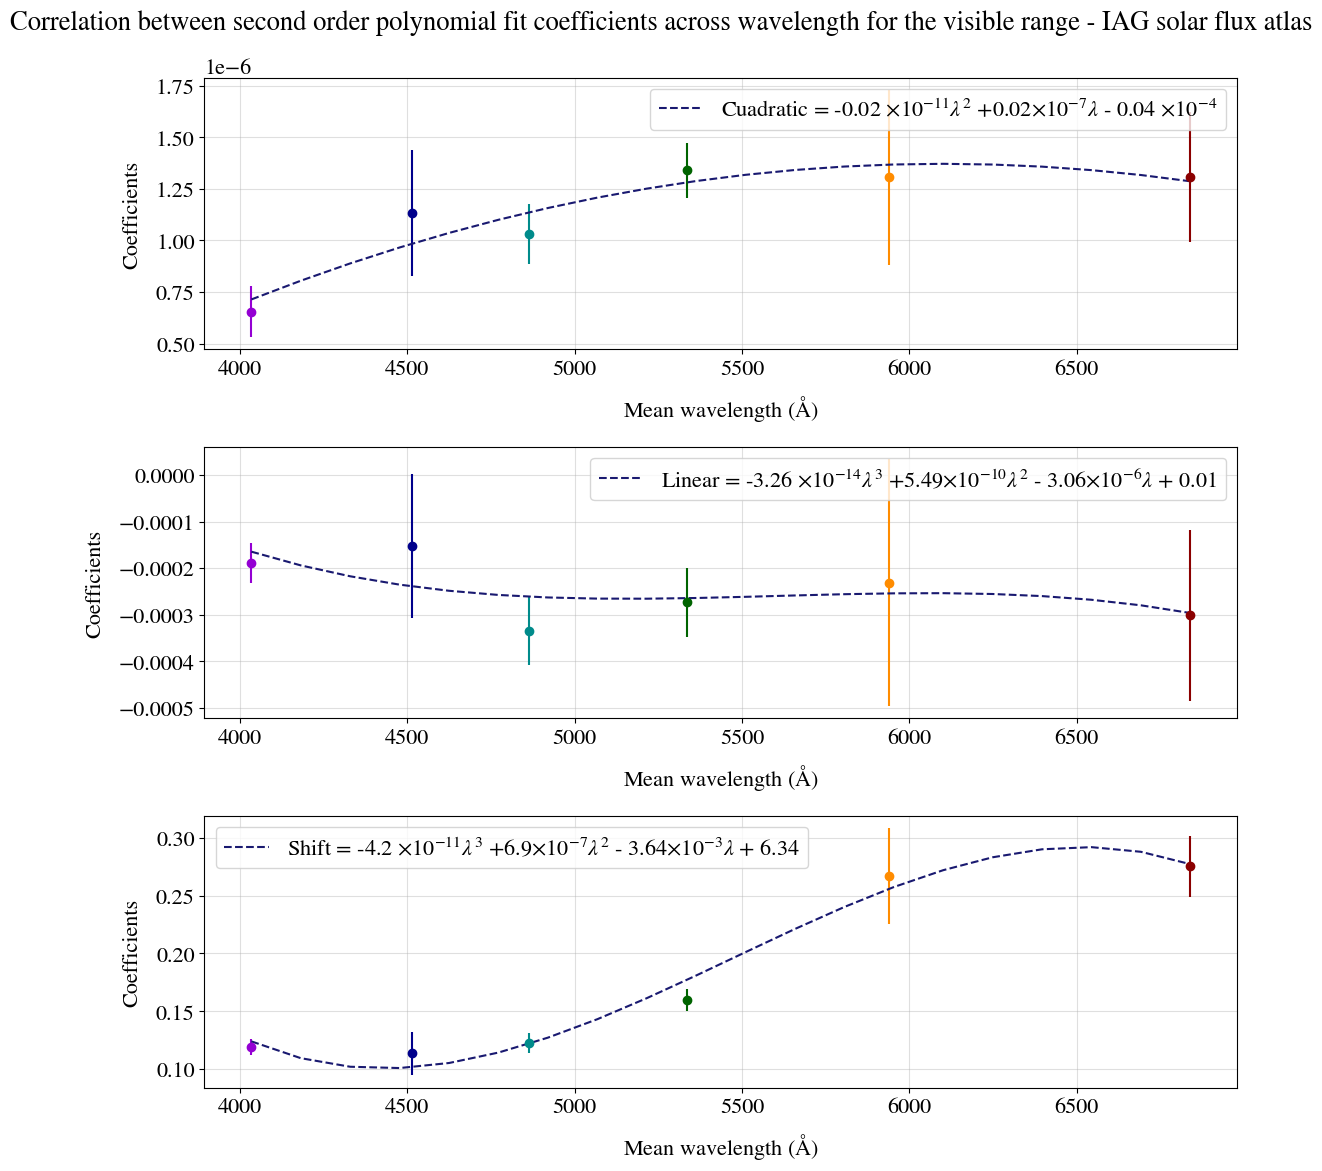

In [ ]:
fig3, axes = plt.subplots(3,1,figsize=(12,12))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

for i in range(len(param_VIS['Range'])):
    ax1.errorbar(param_VIS['Range'][i],param_VIS['Cuadratic'][i],yerr=param_VIS['Error Cuadratic'][i],fmt='o',c=colors[i])
    ax2.errorbar(param_VIS['Range'][i],param_VIS['Lineal'][i],yerr=param_VIS['Error Lineal'][i],fmt='o',c=colors[i])
    ax3.errorbar(param_VIS['Range'][i],param_VIS['Shift'][i],yerr=param_VIS['Error Shift'][i],fmt='o',c=colors[i])

values_fit = np.linspace(min(param_VIS['Range']), max(param_VIS['Range']), 20)

#Made a polynomial first order fit
param0, cov = np.polyfit(param_VIS['Range'],param_VIS['Shift'], 3,cov=True)
fit = np.polyval(param0,values_fit)

ax3.plot(values_fit,fit,c='midnightblue',linestyle='--',label=rf'Shift = {round(param0[0]*1e11,2)} $\times 10^{{-11}}\lambda^3$ +{round(param0[1]*1e7,2)}$\times 10^{{-7}}\lambda^2$ - {round(param0[2]*-1e3,2)}$\times 10^{{-3}}\lambda$ + {round(param0[3],2)}')

#Made a polynomial first order fit
param1, cov1 = np.polyfit(param_VIS['Range'],param_VIS['Lineal'], 3,cov=True)
fit = np.polyval(param1,values_fit)

ax2.plot(values_fit,fit,c='midnightblue',linestyle='--',label=rf'Linear = -{round(param1[0]*-1e14,2)} $\times 10^{{-14}}\lambda^3$ +{round(param1[1]*1e10,2)}$\times 10^{{-10}}\lambda^2$ - {round(param1[2]*-1e6,2)}$\times 10^{{-6}}\lambda$ + {round(param1[3],2)}')

#Made a polynomial first order fit
param2, cov = np.polyfit(param_VIS['Range'],param_VIS['Cuadratic'], 2,cov=True)
fit = np.polyval(param2,values_fit)

ax1.plot(values_fit,fit,c='midnightblue',linestyle='--',label=rf'Cuadratic = {round(param2[0]*1e11,2)} $\times 10^{{-11}}\lambda^2 $ +{round(param2[1]*1e7,2)}$\times 10^{{-7}}\lambda$ - {round(param2[2]*-1e4,2)} $\times 10^{{-4}}$')

fig3.suptitle('Correlation between second order polynomial fit coefficients across wavelength for the visible range - IAG solar flux atlas')

ax1.set_xlabel(r'Mean wavelength ($\mathrm{\AA}$)',labelpad=10)
ax2.set_xlabel(r'Mean wavelength ($\mathrm{\AA}$)',labelpad=10)
ax3.set_xlabel(r'Mean wavelength ($\mathrm{\AA}$)',labelpad=10)

ax1.set_ylabel(r'Coefficients',labelpad=10)
ax2.set_ylabel(r'Coefficients',labelpad=10)
ax3.set_ylabel(r'Coefficients',labelpad=10)

ax1.grid(alpha = 0.4)
ax2.grid(alpha = 0.4)
ax3.grid(alpha = 0.4)
ax1.legend()
ax2.legend()
ax3.legend()
fig3.tight_layout()

# fig3.savefig('color characterization coeff VIS')

### Standard curves for near infrared range

In [11]:
values_NIR = [ ALL_data[ALL_data['Observed wavelength'].between(7000, 9500, inclusive='right') ],
                ALL_data[ALL_data['Observed wavelength'].between(9500, 11500, inclusive='right')], 
                ALL_data[ALL_data['Observed wavelength'].between(11500, 14000, inclusive='right')], 
                ALL_data[ALL_data['Observed wavelength'].between(14000, 16000, inclusive='right')],
                ALL_data[ALL_data['Observed wavelength'].between(16000, 19000, inclusive='right')]]

#colors for the plot
colors_nir = ['darkred','brown','chocolate','indianred','darksalmon']

#colors for the plot
colors_fit_nir = [r'7000 $\mathrm{\AA}$ - 9500 $\mathrm{\AA}$',r'9500 $\mathrm{\AA}$ - 11500 $\mathrm{\AA}$',r'11500 $\mathrm{\AA}$ - 14000 $\mathrm{\AA}$',
              r'14000 $\mathrm{\AA}$ - 16000 $\mathrm{\AA}$',r'16000 $\mathrm{\AA}$ - 19000 $\mathrm{\AA}$']

colors_wave_nir = [np.mean(np.arange(7000, 9500,1)),np.mean(np.arange(9500, 11500,1)),np.mean(np.arange(11500, 14000,1)),
               np.mean(np.arange(14000, 16000,1)),np.mean(np.arange(16000, 19000,1))]


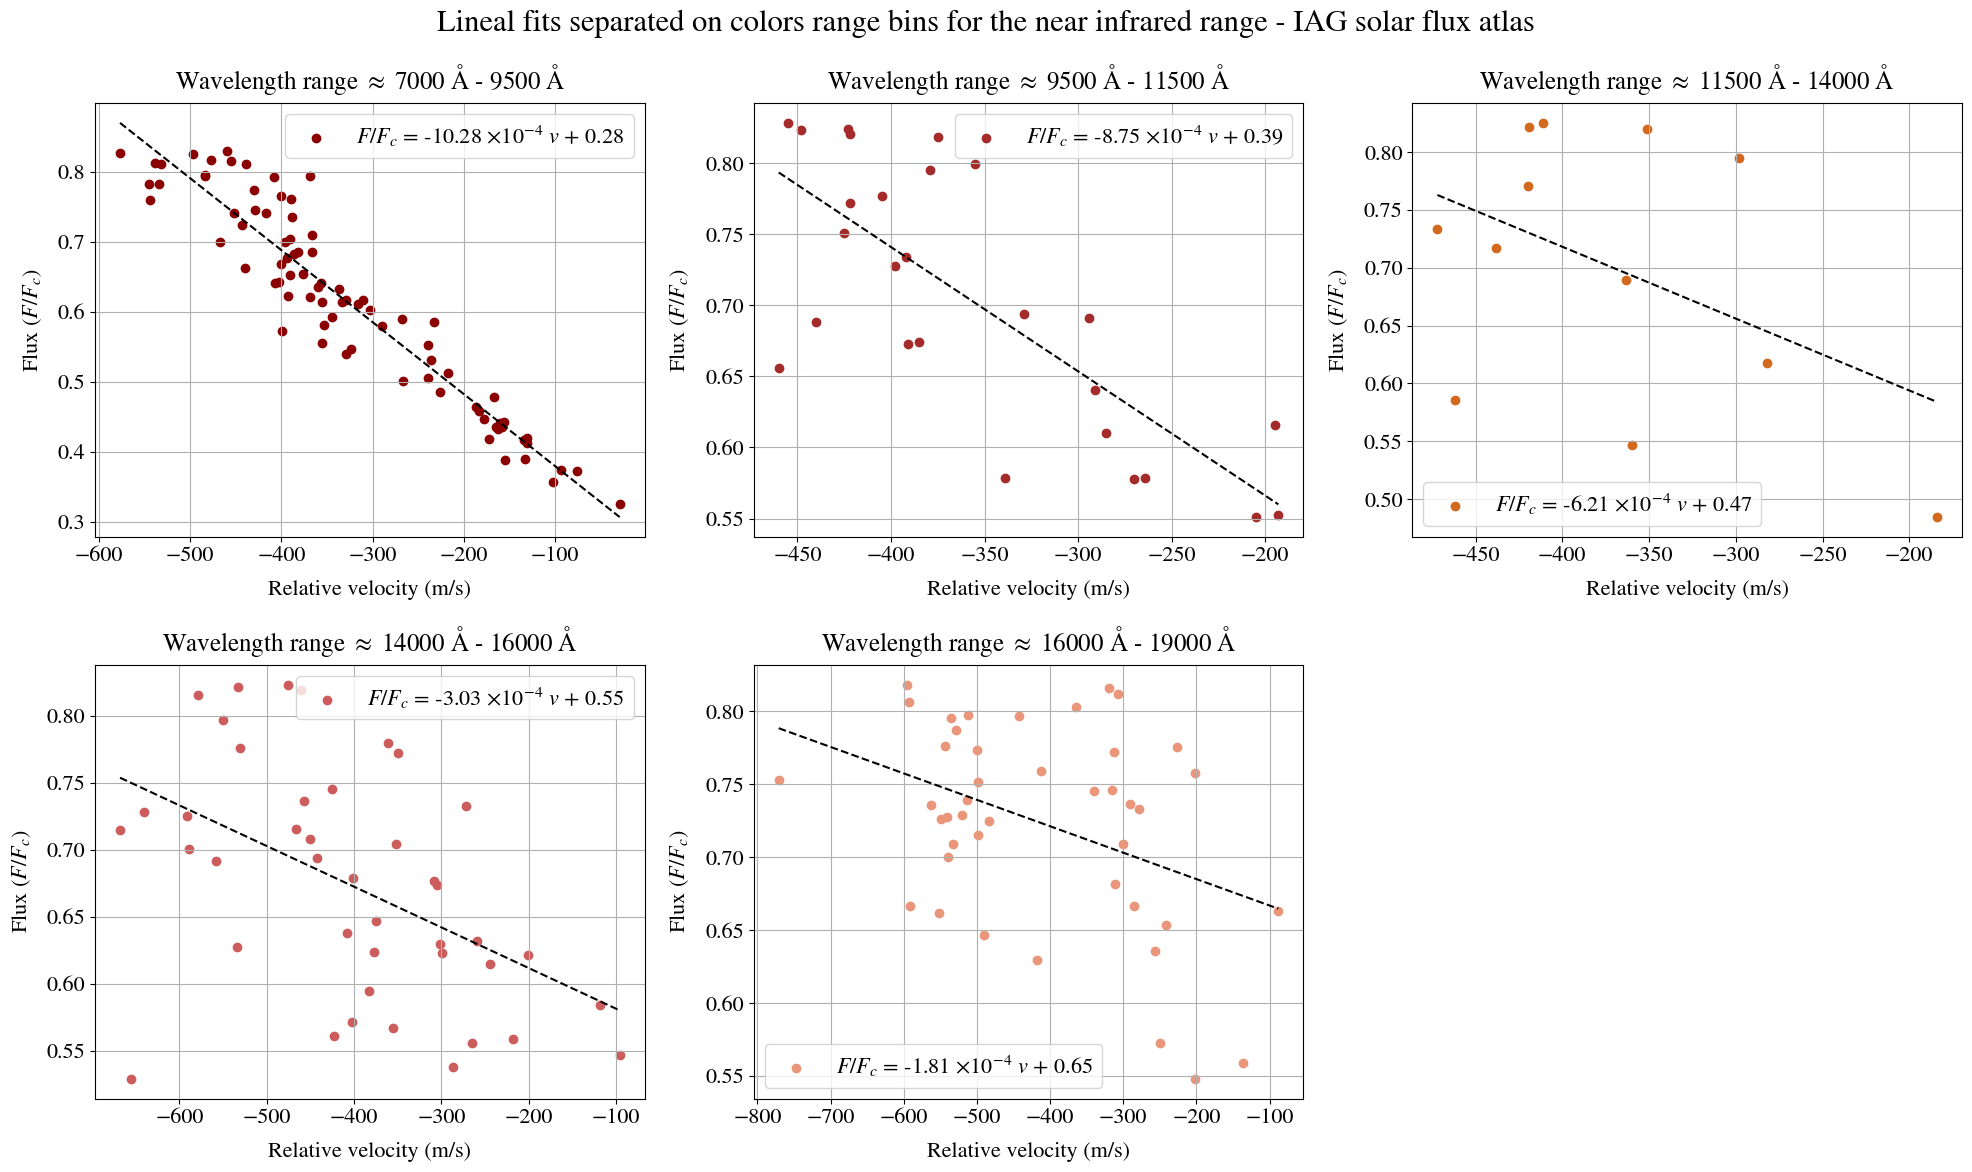

In [ ]:
fig5, axes = plt.subplots(2,3,figsize=(20,12))
fig5.suptitle('Lineal fits separated on colors range bins for the near infrared range - IAG solar flux atlas',fontsize=22)
axes = axes.flatten()

cov_error = []
fits = []
values_param = []

#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):
        if i < len(values_NIR):
                data = values_NIR[i][values_NIR[i]['Flux'].between(0,0.83)]

                ax.set_title(r'Wavelength range $\approx$ {}'.format(colors_fit_nir[i]),pad=10)
                ax.grid()
                
                #Made a polynomial first order fit
                param, cov = np.polyfit(data['Velocity'],data['Flux'], 1,cov=True)
                values_fit = np.linspace(min(data['Velocity']), max(data['Velocity']), len(data))
                fit = np.polyval(param,values_fit)
                # Standard error
                error = np.sqrt(np.diag(cov))
                #Calcule the pearson coeffcient where R2=r2
                r = data['Velocity'].corr(pd.Series(fit, index=data.index))

                cov_error.append(pd.DataFrame(error))
                fits.append([values_fit,fit])
                values_param.append(pd.DataFrame(param))

                ax.plot(values_fit,fit, color='k',linestyle='--')
                ax.scatter(data['Velocity'],data['Flux'],c=colors_nir[i],label=rf'$F/F_c$ = {round(param[0]*1e4,2)} $\times 10^{{-4}}$ $v$ + {round(param[1],2)}')
                ax.legend()
                ax.set_ylabel(r'Flux $(F/F_{c})$',labelpad=10)
                ax.set_xlabel(r'Relative velocity (m/s)',labelpad=10)
        else:
                ax.remove()

fig5.tight_layout()

# fig5.savefig('color curves NIR')

In [13]:
#Parameters and their error
param_NIR = pd.concat(values_param,axis=1).T.reset_index(drop=True)
param_NIR.columns = ['Lineal','Shift']
param_NIR['Error Lineal'] = pd.concat(cov_error,axis=1).T.reset_index(drop=True)[0]
param_NIR['Error Shift'] = pd.concat(cov_error,axis=1).T.reset_index(drop=True)[1]
param_NIR['Range'] = colors_wave_nir
param_NIR['Color range'] = colors_fit_nir

param_NIR

,Lineal,Shift,Error Lineal,Error Shift,Range,Color range
0,-0.001028,0.276968,0.000039,0.013782,8249.5,7000 $\mathrm{\AA}$ - 9500 $\mathrm{\AA}$
1,-0.000875,0.391186,0.000152,0.055238,10499.5,9500 $\mathrm{\AA}$ - 11500 $\mathrm{\AA}$
2,-0.000621,0.469690,0.000392,0.149210,12749.5,11500 $\mathrm{\AA}$ - 14000 $\mathrm{\AA}$
3,-0.000303,0.550961,0.000085,0.036374,14999.5,14000 $\mathrm{\AA}$ - 16000 $\mathrm{\AA}$
4,-0.000181,0.648775,0.000066,0.028858,17499.5,16000 $\mathrm{\AA}$ - 19000 $\mathrm{\AA}$


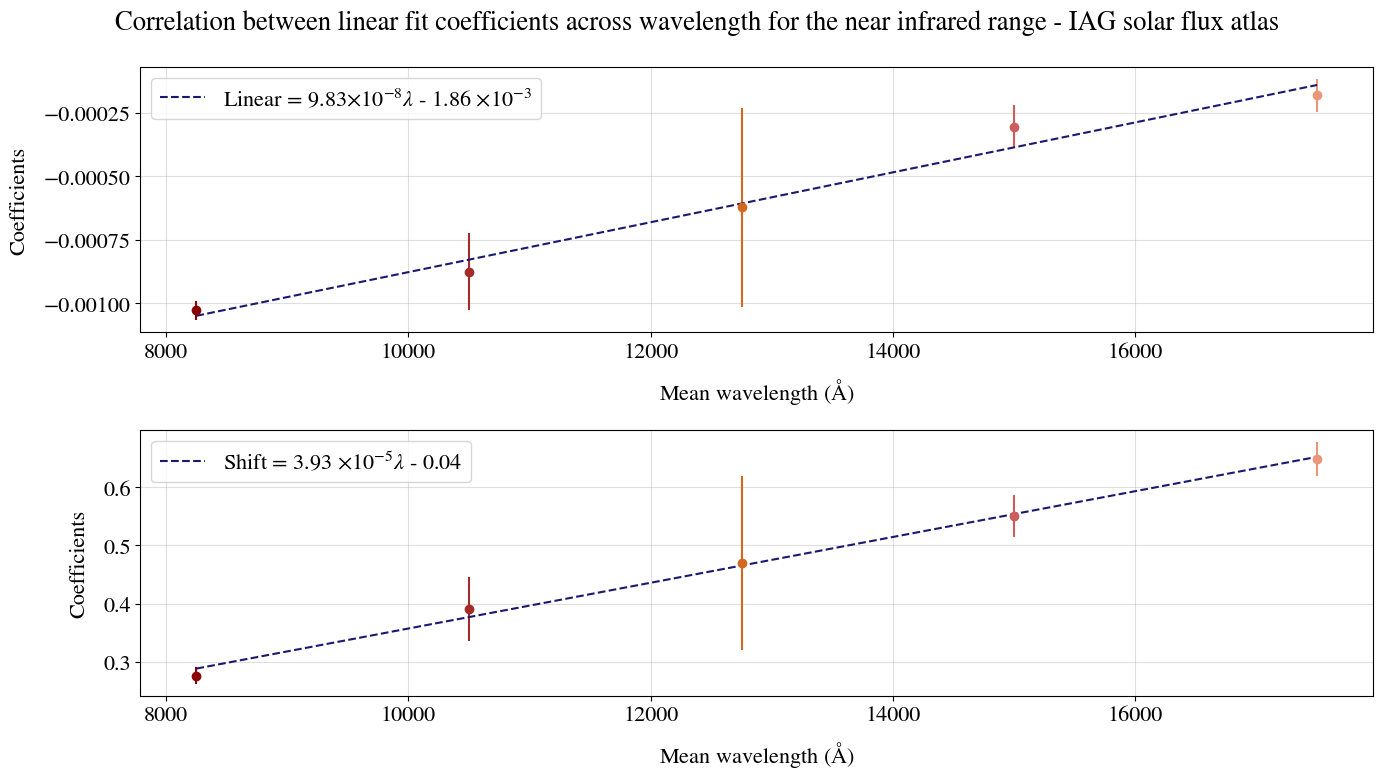

In [14]:
fig3, axes = plt.subplots(2,1,figsize=(14,8))
ax2 = axes[0]
ax3 = axes[1]

for i in range(len(param_NIR)):
    ax2.errorbar(param_NIR['Range'][i],param_NIR['Lineal'][i],yerr=param_NIR['Error Lineal'][i],fmt='o',c=colors_nir[i])
    ax3.errorbar(param_NIR['Range'][i],param_NIR['Shift'][i],yerr=param_NIR['Error Shift'][i],fmt='o',c=colors_nir[i])

values_fit = np.linspace(min(param_NIR['Range']), max(param_NIR['Range']), 20)

#Made a polynomial first order fit
param0, cov = np.polyfit(param_NIR['Range'],param_NIR['Shift'], 1,cov=True)
fit = np.polyval(param0,values_fit)

ax3.plot(values_fit,fit,c='midnightblue',linestyle='--',label=rf'Shift = {round(param0[0]*1e5,2)} $\times 10^{{-5}}\lambda$ - {round(param0[1]*-1,2)}')

#Made a polynomial first order fit
param1, cov1 = np.polyfit(param_NIR['Range'],param_NIR['Lineal'], 1,cov=True)
fit = np.polyval(param1,values_fit)

ax2.plot(values_fit,fit,c='midnightblue',linestyle='--',label=rf'Linear = {round(param1[0]*1e8,2)}$\times 10^{{-8}}\lambda$ - {round(param1[1]*-1e3,2)} $\times 10^{{-3}}$')


fig3.suptitle('Correlation between linear fit coefficients across wavelength for the near infrared range - IAG solar flux atlas')

ax1.set_xlabel(r'Mean wavelength ($\mathrm{\AA}$)',labelpad=10)
ax2.set_xlabel(r'Mean wavelength ($\mathrm{\AA}$)',labelpad=10)
ax3.set_xlabel(r'Mean wavelength ($\mathrm{\AA}$)',labelpad=10)

ax1.set_ylabel(r'Coefficients',labelpad=10)
ax2.set_ylabel(r'Coefficients',labelpad=10)
ax3.set_ylabel(r'Coefficients',labelpad=10)

ax1.grid(alpha = 0.4)
ax2.grid(alpha = 0.4)
ax3.grid(alpha = 0.4)
ax1.legend()
ax2.legend()
ax3.legend()
fig3.tight_layout()

# fig3.savefig('color characterization coeff NIR')